In [1]:

import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

import numpy as np

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# tf.config.run_functions_eagerly(False)

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

tf.autograph.set_verbosity(
    level=3, alsologtostdout=False
)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# tf.debugging.enable_check_numerics()

In [2]:
PATCH_SIZE = 256
BATCH_SIZE = 16

LAMBDA_VALUE = 0.1
FILTERS = 256
LATENT = 64

STEPS_PER_EPOCH = 500
EPOCHS = 100

MODEL_NAME = f"end-to-end-{LATENT}-int"
MODEL_PATH = f"models/{MODEL_NAME}/"


In [3]:
def make_analysis_transform(num_filters, latent_space):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Lambda(lambda x: x / 255.),
      tfc.SignalConv2D(
        num_filters, (9, 9), name="layer_0", corr=True, strides_down=4,
        padding="same_zeros", use_bias=True,
        activation=tfc.GDN(name="gdn_0")),
      tfc.SignalConv2D(
        num_filters, (5, 5), name="layer_1", corr=True, strides_down=2,
        padding="same_zeros", use_bias=True,
        activation=tfc.GDN(name="gdn_1")),
      tfc.SignalConv2D(
        latent_space, (5, 5), name="layer_2", corr=True, strides_down=2,
        padding="same_zeros", use_bias=False,
        activation=None)
  ], name="analysis_transform")


In [4]:
def make_synthesis_transform(num_filters):
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tfc.SignalConv2D(
        num_filters, (5, 5), name="layer_0", corr=False, strides_up=2,
        padding="same_zeros", use_bias=True,
        activation=tfc.GDN(name="igdn_0", inverse=True)),
      tfc.SignalConv2D(
        num_filters, (5, 5), name="layer_1", corr=False, strides_up=2,
        padding="same_zeros", use_bias=True,
        activation=tfc.GDN(name="igdn_1", inverse=True)),
      tfc.SignalConv2D(
        3, (9, 9), name="layer_2", corr=False, strides_up=4,
        padding="same_zeros", use_bias=True,
        activation=None),
      tf.keras.layers.Lambda(lambda x: x * 255.),
  ], name="synthesis_transform")


In [5]:
class ModelSaveCheckpoint(tf.keras.callbacks.Callback):
  def __init__(self, model, name):
    super(ModelSaveCheckpoint, self).__init__()
    self.model = model
    self.name = name

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      self.model.save_weights("models/checkpoints/{}/{}_{}.h5".format(self.name, self.name, epoch))

In [6]:
class CompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for ."""

  def __init__(self, latent_dims, num_filters, target_rate, target_distortion):
    super().__init__()
    self.analysis_transform = make_analysis_transform(num_filters, latent_dims)
    self.synthesis_transform = make_synthesis_transform(num_filters)
    self.prior = tfc.DeepFactorized(batch_shape=(latent_dims,), dtype=tf.float32)
    self.target_rate = target_rate
    self.target_distortion = target_distortion

  def call(self, x, training):
    """Computes rate and distortion losses."""
  
    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    y = tf.round(y)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=3, compression=False)
    
    y_tilde, bits = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    num_pixels = tf.cast(tf.reduce_prod(tf.shape(x)[:-1]), bits.dtype)
    bpp = tf.reduce_sum(bits) / num_pixels

    rate = bpp

    distortion = tf.reduce_mean(tf.math.squared_difference(x, x_tilde))
  
    return dict(rate=rate, distortion=distortion)

In [7]:
def check_image_size(image, patchsize):
  shape = tf.shape(image)
  return shape[0] >= patchsize and shape[1] >= patchsize and shape[-1] == 3

def crop_image(image, patchsize):
  image = tf.image.random_crop(image, (patchsize, patchsize, 3))
  return tf.cast(image, tf.keras.mixed_precision.global_policy().compute_dtype)


In [8]:
def get_dataset(name, split):
    with tf.device("/cpu:0"):
        dataset = tfds.load(name, split=split, shuffle_files=True)
        if split == "train":
            dataset = dataset.repeat()
        dataset = dataset.filter(
            lambda x: check_image_size(x["image"], PATCH_SIZE))
        dataset = dataset.map(
            lambda x: crop_image(x["image"], PATCH_SIZE))
    return dataset

In [9]:
training_dataset = get_dataset("clic", "train")
validation_dataset = get_dataset("clic", "validation")

In [10]:
image = validation_dataset.skip(1).take(1)
image = next(iter(image))

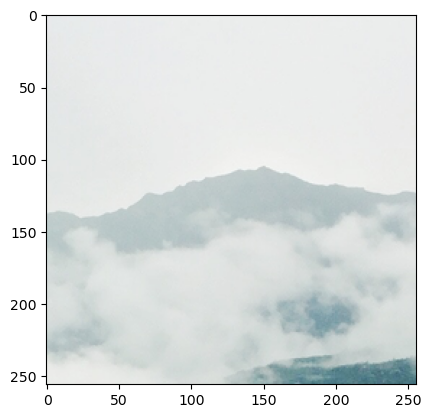

In [11]:
plt.imshow(image.numpy().astype(np.uint8))

In [12]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_compression_trainer(target_rate, target_distortion, lmbda,  latent_dims, num_filters):
  trainer = CompressionTrainer(latent_dims, num_filters, target_rate, target_distortion)
  
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda)
  )
  return trainer

In [13]:
def add_rd_targets(image):
  return image, dict(rate=0., distortion=0.)


In [14]:
def regulate_lr(epoch, lr):
    lrs = [1e-4, 1e-5, 1e-6, 1e-7]
    step = 20
    count = epoch // step
    if count < len(lrs):
        return lrs[count]
    return lrs[-1]

In [15]:
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(f"models/checkpoints/{MODEL_NAME}", exist_ok=True)

In [ ]:
def train_model(lmbda, target_rate, target_distortion):
  trainer = make_compression_trainer(target_rate, target_distortion, lmbda, LATENT, FILTERS)
  trainer.build((None, 256, 256,  3))
  trainer.summary()

  scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, min_delta=1)
#   scheduler = tf.keras.callbacks.LearningRateScheduler(
#         regulate_lr, verbose=1)

  history = trainer.fit(
      training_dataset.map(add_rd_targets).batch(BATCH_SIZE).prefetch(16),
      epochs=EPOCHS,
      verbose=1,
      use_multiprocessing=True,
      workers=4,
      steps_per_epoch=STEPS_PER_EPOCH,
      callbacks=[
          tf.keras.callbacks.TerminateOnNaN(),
          tf.keras.callbacks.TensorBoard(
              log_dir=MODEL_PATH,
              histogram_freq=1, update_freq="epoch"),
          tf.keras.callbacks.BackupAndRestore(MODEL_PATH),
          ModelSaveCheckpoint(trainer, MODEL_NAME),
          scheduler
      ],
      validation_data=validation_dataset.map(add_rd_targets).batch(BATCH_SIZE))
  
  return trainer, history

trainer, history = train_model(lmbda=LAMBDA_VALUE, target_rate=0, target_distortion=0)

Model: "compression_trainer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 analysis_transform (Sequen  (None, 16, 16, 64)        2658816   
 tial)                                                           
                                                                 
 synthesis_transform (Seque  (None, 256, 256, 3)       2658819   
 ntial)                                                          
                                                                 
Total params: 5319427 (20.29 MB)
Trainable params: 5319427 (20.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 13/100
370/500 [=====================>........] - ETA: 1:26 - loss: 23158.3652 - distortion_loss: 723.6835 - rate_loss: 0.4935

In [ ]:
trainer.save_weights(f"models/{MODEL_NAME}.h5")

In [ ]:
trainer = make_compression_trainer(lmbda=LAMBDA_VALUE, target_rate=0., target_distortion=0, latent_dims=LATENT, num_filters=FILTERS)
# Load the weights of the trained model.
trainer.build((None, None, None, 3))
trainer.load_weights(f"models/checkpoints/{MODEL_NAME}/{MODEL_NAME}_25.h5")
# # # # # trainer = tf.keras.models.load_model("models/end-to-end-big/", compile=False)

In [ ]:
class Compressor(tf.keras.Model):
  """Compresses  images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model
    self.y = None

  def call(self, x):
    self.y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(self.y, training=False)
    return self.entropy_model.compress(self.y), bits

In [ ]:
class Decompressor(tf.keras.Model):
  """Decompresses  images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, (), )
    x_hat = self.synthesis_transform(y_hat)
    return x_hat


In [ ]:
def make_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_codec(trainer, decode_sanity_check=False)


In [ ]:
originals = validation_dataset.batch(1).take(1)
originals = next(iter(originals))
# originals, _ = preprocess(originals, None)

In [ ]:
strings, entropies = compressor(originals)

In [ ]:
print(compressor.y.shape[1:-1])
print(strings.shape)

In [ ]:
reconstructions = decompressor(strings)
reconstructions = tf.cast(reconstructions, tf.uint8)

In [ ]:
# originals = tf.image.yuv_to_rgb(originals)
originals = tf.saturate_cast(originals, tf.uint8)

In [ ]:
# Display the original and reconstructed images.
plt.figure(figsize=(30, 30))
for i, (original, reconstruction) in enumerate(zip(originals, reconstructions)):
  plt.subplot(4, 8, 2 * i + 1)
  plt.imshow(tf.squeeze(original))
  plt.axis("off")
  plt.subplot(4, 8, 2 * i + 2)
  plt.imshow(tf.squeeze(reconstruction))
  plt.axis("off")

In [ ]:
strings = tf.reshape(strings, (1, -1))
strings = tf.squeeze(strings).numpy()

In [ ]:
bits = sum([len(string)*8 for string in strings])
pixels = 256**2
bits/pixels

In [ ]:
tf.image.ssim(originals, reconstruction, max_val=255)

In [ ]:
def pad_image(image: np.ndarray, patch_size: int):
 
    h, w, c = image.shape
    h_pad = (patch_size - (h % patch_size)) % patch_size
    w_pad = (patch_size - (w % patch_size)) % patch_size

    return np.pad(image, ((0, h_pad), (0, w_pad), (0, 0)), mode='edge'), h_pad, w_pad

In [ ]:
def compress_image(image: np.ndarray, compressor, decompressor) -> tuple[np.ndarray, np.ndarray]:
    patch_size = 32

    # pad the image
    image *= 255.
    image, h_pad, w_pad = pad_image(image, patch_size)
    
    height, width, channels = image.shape
    
    # transform image to list with a single element
    image = tf.expand_dims(image, axis=0)

    strings, entropies = compressor(image)

    reconstructed_image = decompressor(strings)
    reconstructed_image = tf.squeeze(reconstructed_image)

    height = height - h_pad
    width = width - w_pad

    reconstructed_image = reconstructed_image[:height, :width]

    # convert reconstructed image to tensor
    reconstructed_image = tf.convert_to_tensor(reconstructed_image)
    reconstructed_image = tf.saturate_cast(reconstructed_image, tf.uint8)
    
    return reconstructed_image, strings, entropies

In [ ]:
image = tf.image.decode_image(tf.io.read_file('data/ciob.png'), channels=3, dtype='float32')

image_copy = image

result, strings, entropies = compress_image(image_copy, compressor, decompressor)

image = tf.saturate_cast(image * 255, tf.uint8)
result = tf.saturate_cast(result, tf.uint8)

In [ ]:
strings = strings.numpy()
strings = np.reshape(strings, (-1, np.prod(strings.shape)))
strings = np.squeeze(strings)

entropies = np.reshape(entropies, (-1, np.prod(entropies.shape)))
entropies = np.squeeze(entropies)

In [ ]:
# plot both images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(image))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(result))
print(result.shape)
print(image.shape)

In [ ]:
# get luma component of image and result
image = tf.cast(image, tf.float64) / 255.
result = tf.cast(result, tf.float64) / 255.

image = tf.image.rgb_to_yuv(image)
result = tf.image.rgb_to_yuv(result)

image = image[:, :, 0]
result = result[:, :, 0]

image = tf.expand_dims(image, axis=-1)
result = tf.expand_dims(result, axis=-1)

In [ ]:
tf.image.ssim(image, result, max_val=1)

In [ ]:
tf.image.ssim_multiscale(image, result, max_val=1)

In [ ]:
tf.image.psnr(image, result, max_val=1)

In [ ]:
benchmark_directory = "data/benchmark/"
benchmark_images = tf.io.gfile.glob(benchmark_directory + "*.png")

psnrs = []
ssims = []
ms_ssims = []
rates = []

for image_path in benchmark_images:
    image = tf.image.decode_image(tf.io.read_file(image_path), channels=3, dtype='float32')
    image_copy = image
    result, strings, entropies = compress_image(image_copy, compressor, decompressor)
    
    # flatten the strings
    strings = np.reshape(strings, np.prod(strings.shape))
    strings = np.squeeze(strings)
    
    # calculate the size of the compressed image
    pixels = tf.cast(tf.reduce_prod(tf.shape(image)[-3:-1]), tf.float32)
    bits = sum([len(s) * 8 for s in strings])

    # calculate the compression ratio
    compression_ratio = bits / pixels

    image = tf.saturate_cast(tf.round(image * 255), tf.uint8)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.squeeze(image))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(result))
    plt.axis("off")

    image = tf.cast(image, tf.float64) / 255.
    result = tf.cast(result, tf.float64) / 255.

    image_yuv = tf.image.rgb_to_yuv(image)
    result_yuv = tf.image.rgb_to_yuv(result)

    image = image_yuv[:, :, 0]
    result = result_yuv[:, :, 0]

    image = tf.expand_dims(image, axis=-1)
    result = tf.expand_dims(result, axis=-1)

    ssim = tf.image.ssim(image, result, max_val=1)
    ms_ssim = tf.image.ssim_multiscale(image, result, max_val=1)
    psnr = tf.image.psnr(image_yuv, result_yuv, max_val=1)

    # show ssim, ms-ssim and psnr on the plot
    plt.subplot(1, 3, 3)
    plt.text(0, 0.2, f"SSIM: {ssim.numpy():.4f}", fontsize=12, color='red')
    plt.text(0, 0.4, f"MS-SSIM: {ms_ssim.numpy():.4f}", fontsize=12, color='red')
    plt.text(0, 0.6, f"PSNR: {psnr.numpy():.4f}", fontsize=12, color='red')
    plt.text(0, 0.8, f"Compression Ratio: {compression_ratio.numpy():.4f}", fontsize=12, color='red')
    plt.axis("off")
    # center the text vertically
    plt.tight_layout()

    ssims.append(ssim)
    ms_ssims.append(ms_ssim)
    psnrs.append(psnr)
    rates.append(compression_ratio.numpy())

    plt.show()

print(f"Average SSIM: {np.mean(ssims):.4f}")
print(f"Average MS-SSIM: {np.mean(ms_ssims):.4f}")
print(f"Average PSNR: {np.mean(psnrs):.4f}")
print(f"Average bpp: {np.mean(rates):.4f}")